In [73]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from tensor_type import Tensor
from typing import List, Tuple, Callable, Union, Optional
import pdb

import tqdm

D = 2   # dimension
a = .5
b = 10.
Cov = torch.Tensor([[1.,0.],[0.,1.]])
Cov[0,0] *= a
Cov[1,1] *= b
iCov = torch.inverse(Cov)

def K( p, Mi=torch.eye(D)):
    return torch.squeeze( (p.t()@Mi@p)*.5 )

def U(q):
    return torch.squeeze( q.t()@iCov@q )

def Sa(q, uq, duq, h0, Mi=torch.eye(D)):
    #pdb.set_trace()
    #print(f'In Sa:\nduq = {duq}')
    duq_sqrd = (duq.t()@Mi@duq)[0,0]
    out = 1/torch.sqrt((h0-uq) + duq_sqrd)
    #print(f'Sa out = {out}')
    return out.item()

def dSa(q, uq, duq, h0, Mi=torch.eye(D)):
    #pdb.set_trace()
    out = -3*q*Sa(q,uq, duq, h0, Mi)**3
    #print(f'In dSa:\nout = {out}')
    return out

def Sb(q, uq, duq, h0):
    out = 1/torch.sqrt(h0 - uq/2)
    #print(f'Sb h0 - uq = {h0 - uq/2}')
    return out

def dSb(q, uq, duq, h0):
    out = (-.5*Sb(q, uq, duq, h0)**3)*duq
    #print(f'dSb out = {out}')
    return out
from torch.linalg import norm
def Sc(p0, q0, p, q):
    den =  norm(p0)*norm(q)-norm(q0)*norm(p)
    return 1/den

def dSc(p0, q0, p, q):
    fac1 = (-1/Sc(p0, q0, p, q)**2)
    out = fac1*(norm(p0)*q + norm(q0)*p)

def Ackley(x,a=20,b=.2,c=2*np.pi):
    term1 = -a*torch.exp( -b*torch.sqrt( (1/D)*(x.t()@x) ) )
    term2 = -torch.exp( (1/D)*torch.cos(c*x).t()@torch.ones((D,1)) )
    term3 = a + np.exp(1)
    return torch.squeeze(term1 + term2 + term3)

def DropWave(x):
    num = -(1. + torch.cos(12*(torch.linalg.norm(x))))
    den = .5*(x.t()@x) + 2
    return torch.squeeze(-num/den)/.96

def Holder(x):
    expon = torch.exp(torch.abs(1- torch.linalg.norm(x)/np.pi))
    return torch.squeeze(torch.abs( torch.sin(x[0,0])*torch.cos(x[1,0])*expon ))/20

def Rastrigin(x):
    out = 10*D + (x**2 - 10*torch.cos(2*np.pi*x)).t()@torch.ones((2,1))
    return torch.squeeze(out/77.3) 

def gradient(func, x) -> Tuple[Tensor, Tensor]:
        '''
        *args = [Callable, Tensor, paramstofunc]
        dH calculates callable function and its gradient.
        x: tensor
        Mat: tensor (mass matrix)
        func: is a function to calculate
        returns function output and gradient
        '''
        vec = x[0]
        vec.requires_grad_(True)    # track math operations
        vec.retain_grad()           # keep gradient after backward()
        out    = func(*x)   # calculate given function
        out.backward(gradient=torch.ones(out.size()))  # Calculate grads
        vec_grad = vec.grad.data      # get gradients only
        vec.grad = None             # reset gradient 
        vec.requires_grad_(False)   # stop tracking
        return out.detach().clone(), vec_grad 

def eccentricity(smajor, sminor):
    return np.sqrt(1. - (sminor**2)/(smajor**2))

class SV:
    '''
        Assumes: 
        -potential function is given
    '''
    def __init__(self, U, h, dim):
        self.U   = U
        self.h   = h
        self.dim = dim
            
    def gradient(self,
                 func: Callable,
                 x:    Tensor) -> Tuple[Tensor, Tensor]:
        '''
        dH calculates callable function and its gradient.
        x: tensor
        Mat: tensor (mass matrix)
        func: is a function to calculate
        returns function output and gradient
        '''
        x = x[0]
        x.requires_grad_(True)    # track math operations
        x.retain_grad()           # keep gradient after backward()
        out    = func(x)          # calculate given function
        out.backward(gradient=torch.ones(out.size()))  # Calculate grads
        x_grad = x.grad.data      # get gradients only
        x.grad = None             # reset gradient 
        x.requires_grad_(False)   # stop tracking
        return out.detach().clone(), x_grad 

    def sv1(self, p,q):
                                  # half-step p
        _, g1 = self.gradient(self.U, (q,))
        p     -= .5*self.h*g1
                                  # full-step q
        q     += self.h*p
                                  # half-step p
        _, g2 = self.gradient(self.U, (q,))
        p     -= .5*self.h*g2
        
        return -p,q

class HMC():
    def __init__(self,
                 method,
                 kinetic,
                 potential,
                 dim):
        self.method = method 
        self.K      = kinetic
        self.U      = potential
        self.dim    = dim
        self.M      = torch.eye(D)
        self.Mi     = torch.inverse(self.M)
    
    #def dK(self,p):
    #    return torch.squeeze( self.Mi@p)
        
    def H(self, p, q):
        return torch.squeeze( self.K(p) + self.U(q))
    
    def alpha(self, p0,q0,pstar,qstar):
        a = torch.Tensor([1., torch.exp(self.H(p0,q0)-\
                                        self.H(pstar,qstar))])
        return (torch.min(a)).item()
    def accept(self, a, q0, qstar):
        acceptFlag = False
        u = np.random.uniform(0,1)
        if u < a:
            q0 = qstar
            acceptFlag = True
        else:
            q0 = q0
            acceptFlag = False
        return q0, acceptFlag
    
    def sample(self, q0, time=None, asv=False):
        p0 = torch.randn((2,1))        # sample normal dist
        #print(f'Sampled p0 = {p0}')
        if(asv):
            Pp,Qp = self.method(p0,q0, time, True)     # propagate
        else:
            Pp,Qp = self.method(p0,q0)     # propagate
            
        acc = self.alpha(p0,q0,Pp,Qp)  # get acceptance prob
        return  self.accept(acc, q0, Qp)    # accept/reject

In [2]:
class ASV:
    '''
        Assumes: 
        -potential function is given
    '''
    def __init__(self, grad, K, U, S, dS, h, dim):
        self.grad = grad
        self.K    = K  # kinetic energy
        self.U    = U  # potential energy
        self.S    = S  # sigma function
        self.dS   = dS
        self.h    = h  # step-size
        self.dim  = dim  # dim
    
    def H(self, p ,q):
        return torch.squeeze(self.K(p) + self.U(q))
        
    def G(self,
          p,
          q,
         h0=None) -> Tensor:
        #pdb.set_trace()
        uq, duq = self.grad(self.U, (q,))
        #print(f'In G:\nuq={uq}\nduq={duq}')
        out = ((-1/self.S(q, uq, duq, h0)) *
               (self.dS(q, uq, duq, h0).t()@p))
        return out[0,0]

    def asv1(self, p,q, time, useH0 = False):
        totalSteps = 0.
        H0 = self.H(p,q)
        #print(f'Outer asv1:')
        #print(f'H0 = {H0}')
        if(useH0):
            z = 1 - (self.h/2.)*self.G(p,q,H0)
        else:
            z = 1 - (self.h/2.)*self.G(p,q)
        #print(f'Outer z={z}')
        while(totalSteps < time):
            if(useH0):
                z = z + self.h*self.G(p,q,H0)
            else:
                z = z + self.h*self.G(p,q)
            #print(f'While loop:')
            #print(f'Inner z={z}')
                                      # half-step p
            _, du1 = self.grad(self.U, (q,))
            p     -= .5*self.h*du1/z
            #print(f'du1={du1}\nphalf={p}')
                                      # full-step q
            _, dk1 = self.grad(self.K, (p,))
            q     += self.h*dk1/z
            #print(f'dk1={dk1}\nqfull={q}')
                                    # half-step p
            _, du2 = self.grad(self.U, (q,))
            p     -= .5*self.h*du2/z
            #print(f'du2={du2}\npfull={p}')
            totalSteps += self.h/z
            #print(f'{q}')
            
            #print(f'Total steps = {totalSteps}  ','*'*50)
        return -p,q

### 2-dimensional Gaussian 
$Cov = \begin{bmatrix}
.5 & 0\\
 0 & 10
\end{bmatrix}$

In [3]:
H = .05  # stepsize
Nprops = 20000

In [4]:

sv = SV(U,H,D)
hmc = HMC(sv.sv1, K, U, D)

q0 = torch.Tensor([[10.],[10.]])
samplesSV = np.zeros((D,Nprops))
acceptance_countSV = 0

for n in tqdm.tqdm(range(Nprops)):
    q0, accFlag = hmc.sample(q0)
    if(accFlag):
        acceptance_countSV += 1
    samplesSV[:,n] = q0.numpy()[:,0]

100%|███████████████████████████████████| 20000/20000 [00:12<00:00, 1609.75it/s]


In [5]:
asv = ASV(gradient, K, U, Sa, dSa, H, D)
hmc = HMC(asv.asv1, K, U, D)
q0 = torch.Tensor([[10.],[10.]])
samplesASV = np.zeros((D,Nprops))
acceptance_countASV = 0

for n in tqdm.tqdm(range(Nprops)):
    q0, accFlag = hmc.sample(q0, 1, True)
    if(accFlag):
        acceptance_countASV += 1
    samplesASV[:,n] = q0.numpy()[:,0]

100%|████████████████████████████████████| 20000/20000 [00:39<00:00, 505.90it/s]


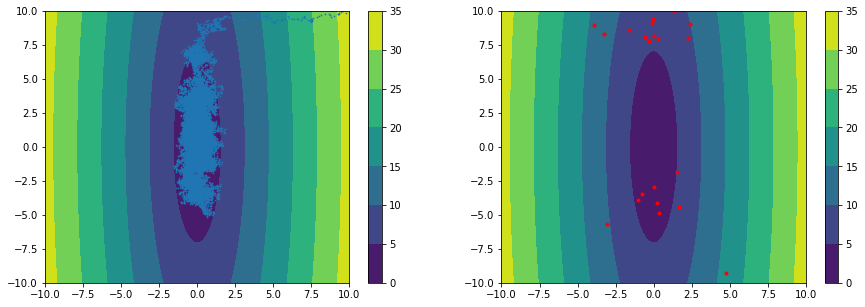

 Acceptance rate SV = 1.0
 Acceptance rate ASV = 0.005


In [6]:
bnd = 10
delta = 0.025

x = np.arange(-bnd, bnd, delta)
y = np.arange(-bnd, bnd, delta)
X, Y = np.meshgrid(x, y)
Z = np.sqrt(b*X**2 + a*Y**2)

fig, ax = plt.subplots(1,2,figsize=(15,5))
cs0 = ax[0].contourf(X, Y, Z)
fig.colorbar(cs0, ax=ax[0])
ax[0].scatter(samplesSV[0,:],samplesSV[1,:], s=.5)
ax[0].set_xlim(-bnd,bnd)
ax[0].set_ylim(-bnd,bnd)



cs1 = ax[1].contourf(X, Y, Z)
fig.colorbar(cs1, ax=ax[1])
ax[1].plot(samplesASV[0,:],samplesASV[1,:], '.r')
ax[1].set_xlim(-bnd,bnd)
ax[1].set_ylim(-bnd,bnd)
plt.show()

print(f' Acceptance rate SV = {acceptance_countSV/Nprops}')
print(f' Acceptance rate ASV = {acceptance_countASV/Nprops}')

### Ackley

$$f(\mathbf{x} = -a\exp\left( -b\lvert|\mathbf{x}\rvert| \right)- \exp\left( \frac{1}{D}\cos(c\mathbf{x})^{\top}\cdot \mathbb{1}\right) + a + \exp(1),$$<br>
where $D$ is dimension and parameters $a=20$, $b=.2$, and $c=2\pi$.<br>
Global minimum $f(\mathbf{x^{*}})=0$ at $\mathbf{x}^* = \mathbf{0}$

In [7]:
sv = SV(Ackley,H,D)
hmc = HMC(sv.sv1, K, Ackley, D)

q0 = torch.Tensor([[20.],[0.]])
samplesSV = np.zeros((D,Nprops))
acceptance_countSV = 0

for n in tqdm.tqdm(range(Nprops)):
    q0, accFlag = hmc.sample(q0)
    if(accFlag):
        acceptance_countSV += 1
    samplesSV[:,n] = q0.numpy()[:,0]

100%|████████████████████████████████████| 20000/20000 [00:30<00:00, 662.60it/s]


In [8]:
#Sigma-b
asv = ASV(gradient, K, Ackley, Sb, dSb, H, D)
hmc = HMC(asv.asv1, K, Ackley, D)
q0 = torch.Tensor([[20.],[0.]])
samplesASVb = np.zeros((D,Nprops))
acceptance_countASV = 0

for n in tqdm.tqdm(range(Nprops)):
    q0, accFlag = hmc.sample(q0, 1, True)
    if(accFlag):
        acceptance_countASV += 1
    samplesASVb[:,n] = q0.numpy()[:,0]

100%|████████████████████████████████████| 20000/20000 [01:19<00:00, 250.34it/s]


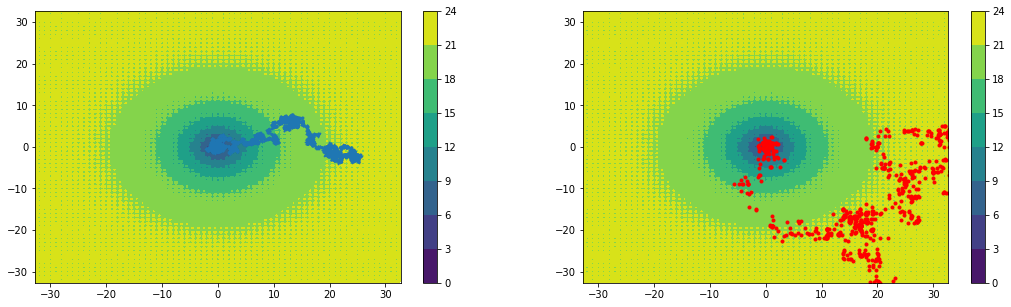

In [10]:
bnd = 32.7
delta = .1
a = 20.
b = .2
c = 2*np.pi

x = np.arange(-bnd, bnd, delta)
y = np.arange(-bnd, bnd, delta)
X, Y = np.meshgrid(x, y)

Z = -a*np.exp(-b*np.sqrt((1/D)*(X**2 + Y**2))) -\
    np.exp((1/D)*(np.cos(c*X)+np.cos(c*Y))) +\
    a + np.exp(1)

fig, ax = plt.subplots(1,2,figsize=(18,5))

cs0 = ax[0].contourf(X, Y, Z)
fig.colorbar(cs0, ax=ax[0])
ax[0].scatter(samplesSV[0,:],samplesSV[1,:], s=.5)
ax[0].set_xlim(-bnd,bnd)
ax[0].set_ylim(-bnd,bnd)

cs1 = ax[1].contourf(X, Y, Z)
fig.colorbar(cs1, ax=ax[1])
ax[1].plot(samplesASVb[0,:],samplesASVb[1,:], '.r')
ax[1].set_xlim(-bnd,bnd)
ax[1].set_ylim(-bnd,bnd)

plt.show()

### Dropwave
$$ f(\mathbf{x}) = -\frac{1+\cos\left( 12\lvert|\mathbf{x}\rvert|\right)}{0.5(\mathbf{x}^{\top}\mathbf{x}) + 2} $$<br>
Global minimum $f(\mathbf{x^{*}})=-1$, at $\mathbf{x}^{*}=(0,0)$


In [53]:
H = .05
Nprops = 20000
sv = SV(DropWave,H,D)
hmc = HMC(sv.sv1, K, DropWave, D)

q0 = torch.Tensor([[3.],[0.]])
samplesSV = np.zeros((D,Nprops))
acceptance_countSV = 0

for n in tqdm.tqdm(range(Nprops)):
    q0, accFlag = hmc.sample(q0)
    if(accFlag):
        acceptance_countSV += 1
    samplesSV[:,n] = q0.numpy()[:,0]

100%|███████████████████████████████████████████████████████| 20000/20000 [00:21<00:00, 929.47it/s]


In [54]:
#Sigma-b
asv = ASV(gradient, K, DropWave, Sb, dSb, H, D)
hmc = HMC(asv.asv1, K, DropWave, D)
q0 = torch.Tensor([[3.],[0.]])
samplesASVb = np.zeros((D,Nprops))
acceptance_countASV = 0

for n in tqdm.tqdm(range(Nprops)):
    q0, accFlag = hmc.sample(q0, 1, True)
    if(accFlag):
        acceptance_countASV += 1
    samplesASVb[:,n] = q0.numpy()[:,0]

100%|████████████████████████████████████████████████████████| 20000/20000 [10:18<00:00, 32.36it/s]


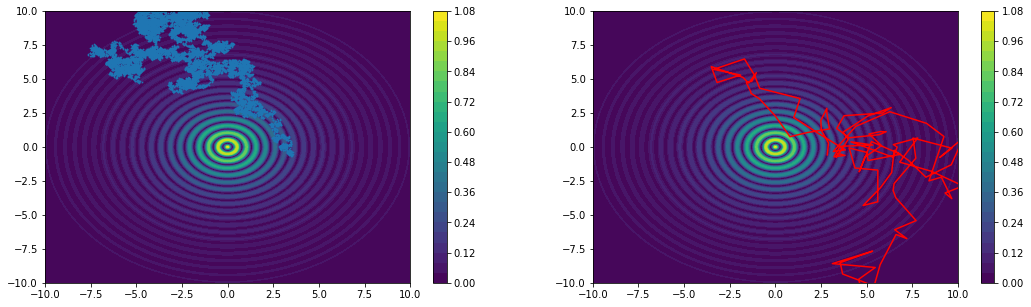

In [57]:
bnd = 10
delta = .01

x = np.arange(-bnd, bnd, delta)
y = np.arange(-bnd, bnd, delta)
X, Y = np.meshgrid(x, y)

Z = (1 + np.cos(12*np.sqrt(X**2 + Y**2)))/(.5*(X**2 + Y**2) + 2)

fig, ax = plt.subplots(1,2,figsize=(18,5))

cs0 = ax[0].contourf(X, Y, Z/.96, levels=30)
fig.colorbar(cs0, ax=ax[0])
ax[0].scatter(samplesSV[0,:],samplesSV[1,:], s=.5)
ax[0].set_xlim(-bnd,bnd)
ax[0].set_ylim(-bnd,bnd)

cs1 = ax[1].contourf(X, Y, Z/.96, levels=30)
fig.colorbar(cs1, ax=ax[1])
ax[1].plot(samplesASVb[0,:],samplesASVb[1,:], '-r')
ax[1].set_xlim(-bnd,bnd)
ax[1].set_ylim(-bnd,bnd)

plt.show()

### Holder

$f(\mathbf{x}) = -\left| \sin(x_1)\cos(x_2) \exp\left(\left|1-\frac{\lVert \mathbf{x}\rVert}{\pi}\right|\right)\right|$<br>

Global minimum $f(\mathbf{x}^*)=-19.021$ at four corners.

In [83]:
H = .05
sv = SV(Holder,H,D)
hmc = HMC(sv.sv1, K, Holder, D)
Nprops = 20000

q0 = torch.Tensor([[5.],[5.]])
samplesSV = np.zeros((D,Nprops))
acceptance_countSV = 0

for n in tqdm.tqdm(range(Nprops)):
    q0, accFlag = hmc.sample(q0)
    if(accFlag):
        acceptance_countSV += 1
    samplesSV[:,n] = q0.numpy()[:,0]

100%|███████████████████████████████████████████████████████| 20000/20000 [00:22<00:00, 909.08it/s]


In [87]:
#Sigma-b
asv = ASV(gradient, K, Holder, Sb, dSb, H, D)
hmc = HMC(asv.asv1, K, Holder, D)
q0 = torch.Tensor([[5.],[5.]])
samplesASVb = np.zeros((D,Nprops))
acceptance_countASV = 0

for n in tqdm.tqdm(range(Nprops)):
    q0, accFlag = hmc.sample(q0, 1, True)
    if(accFlag):
        acceptance_countASV += 1
    samplesASVb[:,n] = q0.numpy()[:,0]

100%|███████████████████████████████████████████████████████| 20000/20000 [00:59<00:00, 334.94it/s]


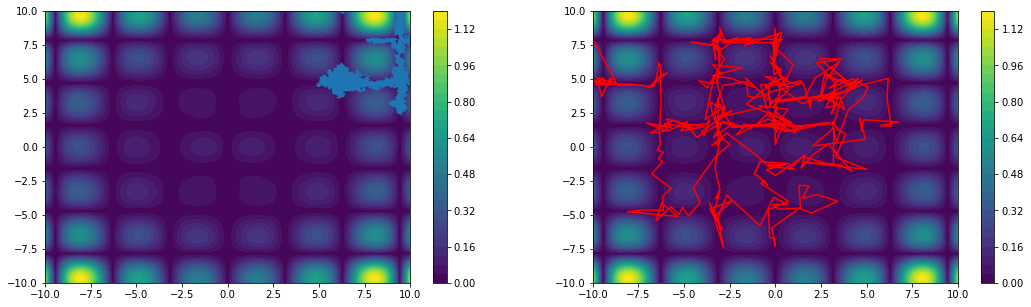

In [88]:
bnd = 10.
delta = .01

x = np.arange(-bnd, bnd, delta)
y = np.arange(-bnd, bnd, delta)
X, Y = np.meshgrid(x, y)

Z = np.abs( np.sin(X)*np.cos(Y)*np.exp(np.abs(1 - np.sqrt(X**2 + Y**2)/np.pi)) )/.81

fig, ax = plt.subplots(1,2,figsize=(18,5))

cs0 = ax[0].contourf(X, Y, Z/20, levels=30)
fig.colorbar(cs0, ax=ax[0])
ax[0].scatter(samplesSV[0,:],samplesSV[1,:], s=.5)
ax[0].set_xlim(-bnd,bnd)
ax[0].set_ylim(-bnd,bnd)

cs1 = ax[1].contourf(X, Y, Z/20, levels=30)
fig.colorbar(cs1, ax=ax[1])
ax[1].plot(samplesASVb[0,:],samplesASVb[1,:], '-r')
ax[1].set_xlim(-bnd,bnd)
ax[1].set_ylim(-bnd,bnd)

plt.show()

### Rastrigan

$$f(\mathbf{x}) = 10 D + [\mathbf{x}^2 - 10 \cos(2\pi\mathbf{x})]^{\top}\cdot\mathbb{1},$$<br>
where $D$ is dimension.<br>
Global minimum $f(\mathbf{x}^*)=0$ at $\mathbf{x}^* = \mathbf{0}$.

In [10]:
sv = SV(Rastrigin,H,D)
hmc = HMC(sv.sv1, K, Rastrigin, D)
Nprops = 20000

q0 = torch.Tensor([[3.],[0.]])
samplesSV = np.zeros((D,Nprops))
acceptance_countSV = 0

for n in tqdm.tqdm(range(Nprops)):
    q0, accFlag = hmc.sample(q0)
    if(accFlag):
        acceptance_countSV += 1
    samplesSV[:,n] = q0.numpy()[:,0]

100%|██████████████████████████████████████████████████████| 20000/20000 [00:19<00:00, 1052.37it/s]


In [11]:
#Sigma-b
asv = ASV(gradient, K, Rastrigin, Sb, dSb, H, D)
hmc = HMC(asv.asv1, K, Rastrigin, D)
q0 = torch.Tensor([[3.],[0.]])
samplesASVb = np.zeros((D,Nprops))
acceptance_countASV = 0

for n in tqdm.tqdm(range(Nprops)):
    q0, accFlag = hmc.sample(q0, 1, True)
    if(accFlag):
        acceptance_countASV += 1
    samplesASVb[:,n] = q0.numpy()[:,0]

100%|████████████████████████████████████████████████████████| 20000/20000 [04:50<00:00, 68.80it/s]


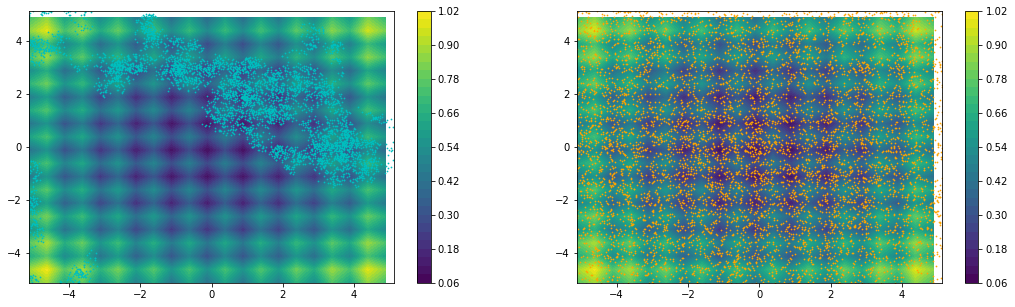

In [16]:
bnd = 5.12
delta = .5

x = np.arange(-bnd, bnd, delta)
y = np.arange(-bnd, bnd, delta)
X, Y = np.meshgrid(x, y)

Z = (10*D + (X**2 -10*np.cos(2*np.pi*X)) + (Y**2 -10*np.cos(2*np.pi*Y)))
fig, ax = plt.subplots(1,2,figsize=(18,5))

cs0 = ax[0].contourf(X, Y, Z/77.3, levels=30)
fig.colorbar(cs0, ax=ax[0])
ax[0].scatter(samplesSV[0,:],samplesSV[1,:], s=.5, c='c')
ax[0].set_xlim(-bnd,bnd)
ax[0].set_ylim(-bnd,bnd)

cs1 = ax[1].contourf(X, Y, Z/77.3, levels=30)
fig.colorbar(cs1, ax=ax[1])
ax[1].scatter(samplesASVb[0,:],samplesASVb[1,:], s=.5, c= 'orange')
ax[1].set_xlim(-bnd,bnd)
ax[1].set_ylim(-bnd,bnd)

plt.show()